Found 5 images

IMG20260204172552.jpg:
  Top 10 contour areas found: [17744.0, 17421.0, 16488.5, 15754.0, 15128.5, 15067.0, 14248.5, 13424.0, 12863.0, 12403.5]
  Detected: 32 explants

IMG20260204172600.jpg:
  Top 10 contour areas found: [76128.0, 52351.0, 46649.5, 44890.0, 40982.5, 40294.5, 39064.5, 37975.0, 36477.0, 35106.0]
  Detected: 33 explants

IMG20260204172607.jpg:
  Top 10 contour areas found: [46962.5, 43071.5, 39178.0, 36859.5, 36689.5, 34530.5, 32898.5, 32429.0, 32411.5, 31500.0]
  Detected: 36 explants

IMG20260204172612.jpg:
  Top 10 contour areas found: [45437.0, 31769.0, 31341.5, 30563.5, 30425.0, 28160.5, 27931.5, 27477.5, 26405.5, 25648.0]
  Detected: 42 explants

IMG20260204172618.jpg:
  Top 10 contour areas found: [63599.0, 42190.0, 41248.5, 38959.0, 38122.0, 33271.5, 32911.0, 30575.5, 30322.5, 29771.0]
  Detected: 34 explants


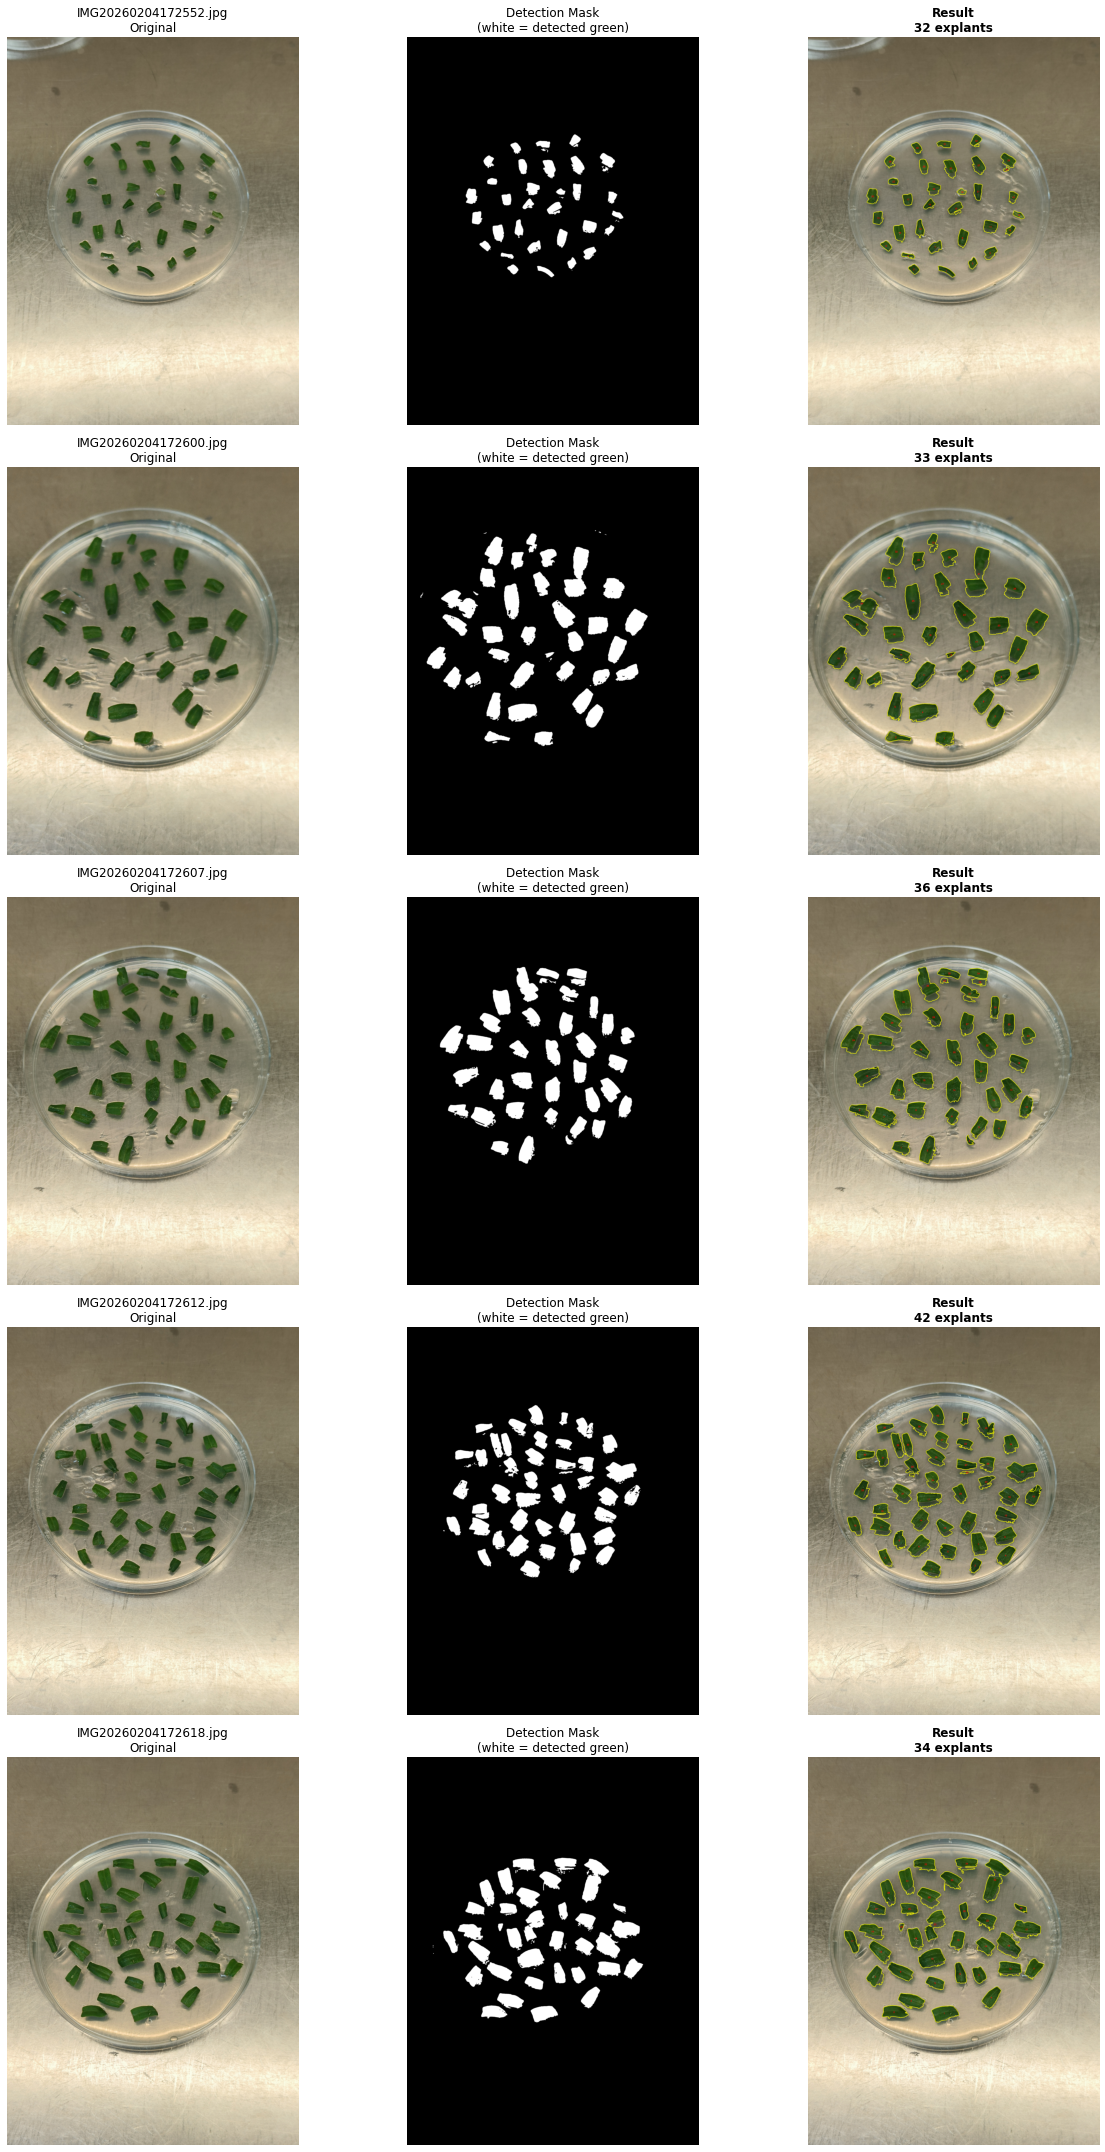


SUMMARY
HSV range: [35 60 50] to [ 85 255 255]
Area range: 1000 to 100000

  IMG20260204172552.jpg: 32 explants
  IMG20260204172600.jpg: 33 explants
  IMG20260204172607.jpg: 36 explants
  IMG20260204172612.jpg: 42 explants
  IMG20260204172618.jpg: 34 explants
TOTAL EXPLANTS: 177


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def count_explants_in_image(image_path, lower_green, upper_green, min_area, max_area, show_debug=False):
    """Count green explants in a single image"""
    img = cv2.imread(str(image_path))
    if img is None:
        return 0, None, None
    
    # Convert BGR to RGB for matplotlib display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV for color segmentation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Create mask
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Show all contour areas for debugging
    if show_debug:
        areas = [cv2.contourArea(c) for c in contours]
        areas.sort(reverse=True)
        print(f"  Top 10 contour areas found: {areas[:10]}")
    
    # Filter by area
    valid_explants = [c for c in contours if min_area < cv2.contourArea(c) < max_area]
    
    # Draw results
    result = img_rgb.copy()
    cv2.drawContours(result, valid_explants, -1, (255, 255, 0), 3)
    
    # Number each explant
    for i, contour in enumerate(valid_explants):
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.putText(result, str(i+1), (cx-10, cy+10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    return len(valid_explants), result, mask

# ========== ADJUST THESE PARAMETERS ==========

# More strict green - higher saturation requirement
lower_green = np.array([35, 60, 50])   # Higher S and V values
upper_green = np.array([85, 255, 255])

min_area = 1000    # Lower this if explants are being missed
max_area = 100000  # Raise this if large explants are being missed

# =============================================

image_folder = Path('image_folder/')
image_files = sorted(image_folder.glob('*.jpg'))

print(f"Found {len(image_files)} images")
print("=" * 60)

results = []
total_count = 0

# Create figure for all images (3 columns: Original, Mask, Result)
n_images = len(image_files)
fig, axes = plt.subplots(n_images, 3, figsize=(18, 6*n_images))

# Handle single image case
if n_images == 1:
    axes = axes.reshape(1, -1)

for i, image_path in enumerate(image_files):
    print(f"\n{image_path.name}:")
    
    count, result, mask = count_explants_in_image(
        image_path, lower_green, upper_green, 
        min_area, max_area, show_debug=True
    )
    
    total_count += count
    results.append((image_path.name, count))
    
    # Load original
    original = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    
    # Column 0: Original
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f'{image_path.name}\nOriginal', fontsize=12)
    axes[i, 0].axis('off')
    
    # Column 1: Mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Detection Mask\n(white = detected green)', fontsize=12)
    axes[i, 1].axis('off')
    
    # Column 2: Result
    axes[i, 2].imshow(result)
    axes[i, 2].set_title(f'Result\n{count} explants', fontsize=12, fontweight='bold')
    axes[i, 2].axis('off')
    
    print(f"  Detected: {count} explants")

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"HSV range: {lower_green} to {upper_green}")
print(f"Area range: {min_area} to {max_area}")
print()
for filename, count in results:
    print(f"  {filename}: {count} explants")
print("=" * 60)
print(f"TOTAL EXPLANTS: {total_count}")
print("=" * 60)

Found 5 images:
  - IMG20260204172552.jpg
  - IMG20260204172600.jpg
  - IMG20260204172607.jpg
  - IMG20260204172612.jpg
  - IMG20260204172618.jpg

TOMATO COTYLEDON EXPLANT COUNTING RESULTS
IMG20260204172552.jpg: 32 explants
IMG20260204172600.jpg: 32 explants
IMG20260204172607.jpg: 36 explants
IMG20260204172612.jpg: 42 explants
IMG20260204172618.jpg: 33 explants


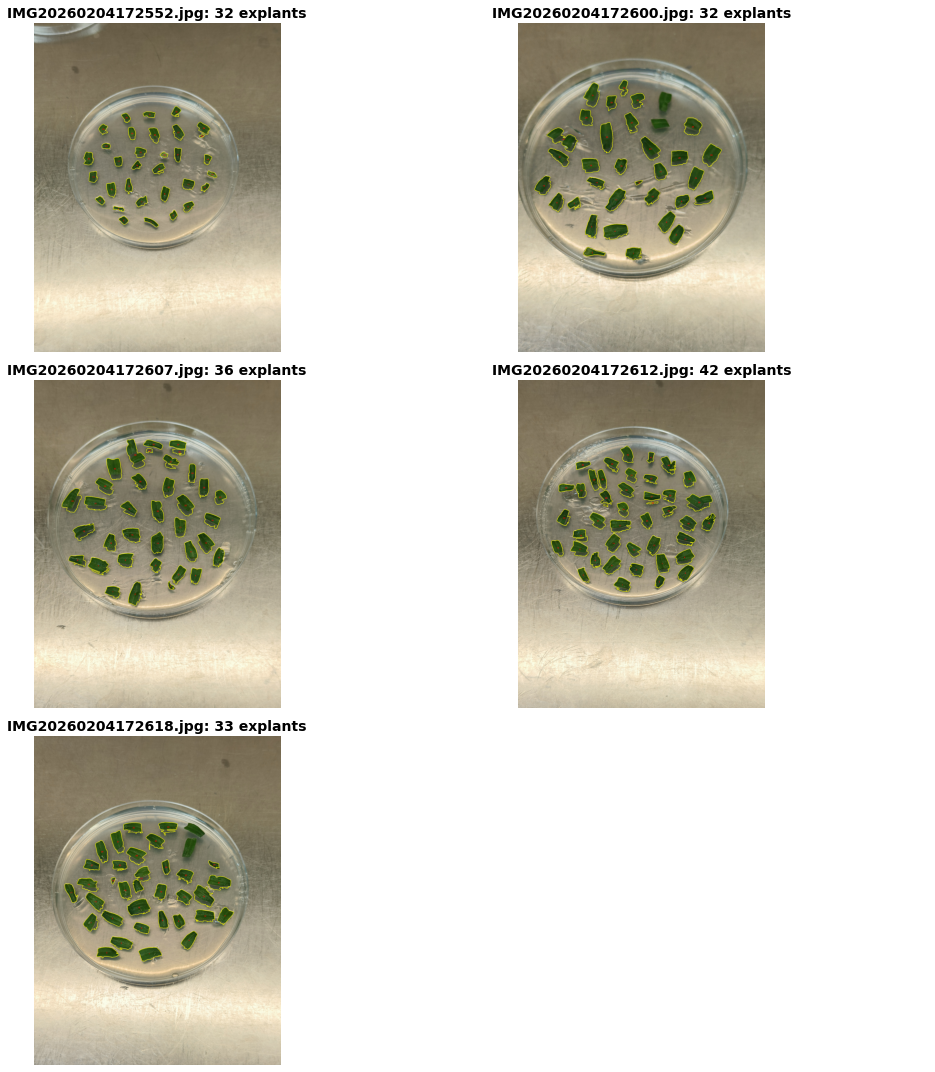

TOTAL EXPLANTS ACROSS ALL PLATES: 175

Summary:
  IMG20260204172552.jpg: 32
  IMG20260204172600.jpg: 32
  IMG20260204172607.jpg: 36
  IMG20260204172612.jpg: 42
  IMG20260204172618.jpg: 33


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def count_explants_in_image(image_path):
    """Count green explants in a single image"""
    img = cv2.imread(str(image_path))
    if img is None:
        return 0, None, None
    
    # Convert BGR to RGB for matplotlib display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV for color segmentation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # More strict green - higher saturation requirement
    lower_green = np.array([35, 60, 50])   # Higher S and V values
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Area filters (in pixels)
    min_area = 1000    # Lower this if explants are being missed
    max_area = 60000  # Raise this if large explants are being missed
    
    valid_explants = [c for c in contours if min_area < cv2.contourArea(c) < max_area]
    
    # Draw results
    result = img_rgb.copy()
    cv2.drawContours(result, valid_explants, -1, (255, 255, 0), 3)  # Yellow outline
    
    # Number each explant
    for i, contour in enumerate(valid_explants):
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.putText(result, str(i+1), (cx-10, cy+10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)  # Red numbers
    
    return len(valid_explants), result, mask

# Automatically detect all .jpg files
image_folder = Path('image_folder/')
image_files = sorted(image_folder.glob('*.jpg'))  # Gets all .jpg files, sorted

print(f"Found {len(image_files)} images:")
for img_file in image_files:
    print(f"  - {img_file.name}")
print()

results = []
total_count = 0

# Calculate grid size based on number of images
n_images = len(image_files)
n_cols = 2
n_rows = (n_images + 1) // 2

# Create figure for all results
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_images == 1:
    axes = np.array([axes])
axes = axes.flatten()

print("=" * 60)
print("TOMATO COTYLEDON EXPLANT COUNTING RESULTS")
print("=" * 60)

for i, image_path in enumerate(image_files):
    count, result_img, mask = count_explants_in_image(image_path)
    
    if result_img is not None:
        results.append((image_path.name, count))
        total_count += count
        
        # Display image
        axes[i].imshow(result_img)
        axes[i].set_title(f'{image_path.name}: {count} explants', fontsize=14, fontweight='bold')
        axes[i].axis('off')
        
        print(f"{image_path.name}: {count} explants")

# Hide extra subplots if any
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print("=" * 60)
print(f"TOTAL EXPLANTS ACROSS ALL PLATES: {total_count}")
print("=" * 60)

# Create a summary table
print("\nSummary:")
for filename, count in results:
    print(f"  {filename}: {count}")